## Import the packages

In [1]:
#%pip install pyreadr
import pyreadr
import sys
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums

## Load and combine the data

In [2]:
result = pyreadr.read_r('./data/brain.rda')
#print(result.keys())
expression = result['expression']
genes = result['genes']
samples = result['samples']
print(expression.shape)
print(samples.shape)

# combine the expression and samples
data = pd.concat([expression, samples], axis=1)

(84, 12600)
(84, 5)


## Exploratory analysis

We first do some exploratory data analysis. We compare the data distribution of female and male, and AC and DLPF from three different labs.

### Female and male

From the following two plots, we see that the distributions of female and male in each lab are similar. However, there exists a substantial difference among the three different labs, where the data in Michigan has the smallest mean value while the data in Irvine has the largest mean value.

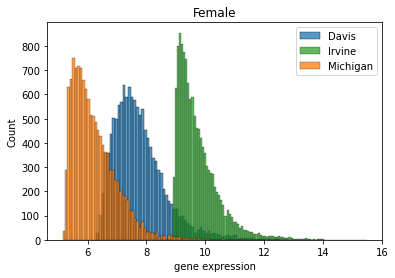

In [3]:
data_sex = data.groupby(['sex', 'lab']).median()
sns.histplot(data_sex.iloc[0,], label = 'Davis', color ='tab:blue')
sns.histplot(data_sex.iloc[1,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_sex.iloc[2,], label = 'Michigan', color = 'tab:orange')

plt.title('Female')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

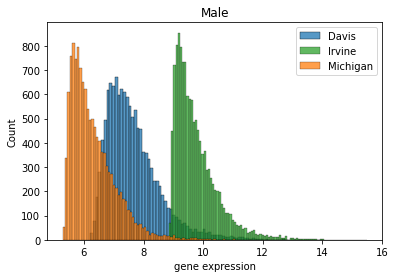

In [4]:
sns.histplot(data_sex.iloc[3,], label = 'Davis', color ='tab:blue')
sns.histplot(data_sex.iloc[4,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_sex.iloc[5,], label = 'Michigan', color = 'tab:orange')

plt.title('Male')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

### AC and DLPF

From the following two plots, we also see that the distributions of AC and DLPF in each lab are similar and there exists a substantial difference among the three different labs.

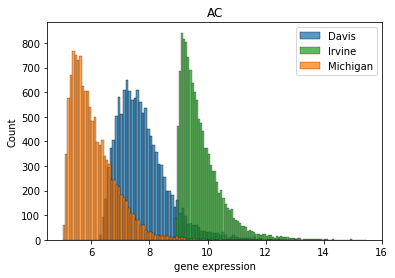

In [5]:
data_region = data.groupby(['region', 'lab']).median()
sns.histplot(data_region.iloc[0,], label = 'Davis', color ='tab:blue')
sns.histplot(data_region.iloc[1,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_region.iloc[2,], label = 'Michigan', color = 'tab:orange')

plt.title('AC')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

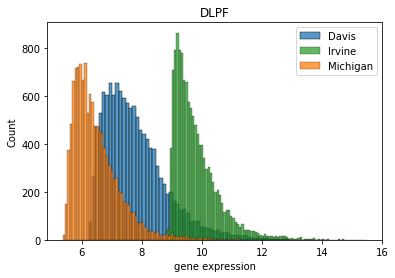

In [6]:
data_region = data.groupby(['region', 'lab']).median()
sns.histplot(data_region.iloc[3,], label = 'Davis', color ='tab:blue')
sns.histplot(data_region.iloc[4,], label = 'Irvine', color = 'tab:green')
sns.histplot(data_region.iloc[5,], label = 'Michigan', color = 'tab:orange')

plt.title('DLPF')
plt.xlabel('gene expression')
plt.legend(labels=['Davis', 'Irvine', 'Michigan']) 

## Wilcoxon rank sum test for sex

We consider a nonparametric statistical test method, the Wilcoxon rank sum test, which compares the population median of two samples. The null hypothesis is that the population distributions of female and male are the same. Next, we run the test in three different labs separately, and also run the test in combined data.

We find that the genes with less than 0.05 p-value in three labs simultaneously are the same as that in the combined data. These genes selected by the Wilcoxon rank sum test are consistent with that of the GLM method and t-test.

### Genes that stand out in three labs simultaneously

In [7]:
# Genes that stand out in davis
data_female_Davis = data[(data['sex'] == 'female') & (data['lab'] == 'Davis')]
data_male_Davis = data[(data['sex'] == 'male') & (data['lab'] == 'Davis')]
p_gender_Davis_all = []
p_gender_Davis_sign = []
idx_gender_Davis = [] 
for i in range(12600):
    p_value = ranksums(data_female_Davis.iloc[:,i], data_male_Davis.iloc[:,i]).pvalue
    p_gender_Davis_all.append(p_value)
    if p_value < 0.05:
        p_gender_Davis_sign.append(p_value)
        idx_gender_Davis.append(expression.columns[i])

# Genes that stand out in irvine
data_female_Irvine = data[(data['sex'] == 'female') & (data['lab'] == 'Irvine')]
data_male_Irvine = data[(data['sex'] == 'male') & (data['lab'] == 'Irvine')]
p_gender_Irvine_all = []
p_gender_Irvine_sign = []
idx_gender_Irvine = []
for i in range(12600):
    p_value = ranksums(data_female_Irvine.iloc[:,i], data_male_Irvine.iloc[:,i]).pvalue
    p_gender_Irvine_all.append(p_value)
    if p_value < 0.05:
        p_gender_Irvine_sign.append(p_value)
        idx_gender_Irvine.append(expression.columns[i])
        
# Genes that stand out in michigan
data_female_Michigan = data[(data['sex'] == 'female') & (data['lab'] == 'Michigan')]
data_male_Michigan = data[(data['sex'] == 'male') & (data['lab'] == 'Michigan')]
p_gender_Michigan_all = []
p_gender_Michigan_sign = []
idx_gender_Michigan = []
for i in range(12600):
    p_value = ranksums(data_female_Michigan.iloc[:,i], data_male_Michigan.iloc[:,i]).pvalue
    p_gender_Michigan_all.append(p_value)
    if p_value < 0.05:
        p_gender_Michigan_sign.append(p_value)
        idx_gender_Michigan.append(expression.columns[i])

# common genes
set(idx_gender_Davis) & set(idx_gender_Irvine) & set(idx_gender_Michigan)

{'38355_at', '41214_at'}

### Genes that stand out in combined data

In [8]:
data_female = data[data['sex'] == 'female']
data_male = data[data['sex'] == 'male']
p_gender_all = []
p_gender_sign = []
idx_gender = []
for i in range(12600):
    p_value = ranksums(data_female.iloc[:,i], data_male.iloc[:,i]).pvalue
    p_gender_all.append(p_value)
    if p_value < 0.05:
        p_gender_sign.append(p_value)
        idx_gender.append(expression.columns[i])
idx_gender

['38355_at', '41214_at']

In [9]:
# genes information
print(genes.loc['38355_at'])
print(genes.loc['41214_at'])

sym      DDX3Y
chrom        Y
Name: 38355_at, dtype: object
sym      RPS4Y1
chrom         Y
Name: 41214_at, dtype: object


### Bonferroni procedure

If we use the Bonferroni procedure with $α=0.1$, no gene stands out. The reason might be that the smallest p-value is not that significant (~0.001) over 12600 comparisons.

In [10]:
fdr_pvalues = multipletests(p_gender_all, alpha=0.1, method='bonferroni')
np.where(fdr_pvalues[0])

(array([], dtype=int64),)

## Wilcoxon rank sum test for region

To find genes that are differentially expressed between ACC and DLPFC, we run the test in three different labs separately, and also run the test in combined data. However, there is no common gene that stands out in three different labs at the same time. For the test in combined data, we observe four genes with p-value lower than 0.1. These four genes are consistent with what we find in the GLM method.

### Genes that stand out in three labs simultaneously

In [11]:
# Genes that stand out in davis
data_AC_Davis = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Davis')]
data_DLPF_Davis = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Davis')]
p_gender_Davis_all = []
p_gender_Davis_sign = []
idx_region_Davis = []
for i in range(12600):
    p_value = ranksums(data_AC_Davis.iloc[:,i], data_DLPF_Davis.iloc[:,i]).pvalue
    p_gender_Davis_all.append(p_value)
    if p_value < 0.1:
        p_gender_Davis_sign.append(p_value)
        idx_region_Davis.append(expression.columns[i])

# Genes that stand out in irvine
data_AC_Irvine = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Irvine')]
data_DLPF_Irvine = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Irvine')]
p_gender_Irvine_all = []
p_gender_Irvine_sign = []
idx_region_Irvine = []
for i in range(12600):
    p_value = ranksums(data_AC_Irvine.iloc[:,i], data_DLPF_Irvine.iloc[:,i]).pvalue
    p_gender_Irvine_all.append(p_value)
    if p_value < 0.1:
        p_gender_Irvine_sign.append(p_value)
        idx_region_Irvine.append(expression.columns[i])

# Genes that stand out in michigan
data_AC_Michigan = data[(data['region'] == 'A.C. cortex') & (data['lab'] == 'Michigan')]
data_DLPF_Michigan = data[(data['region'] == 'D.L.P.F. cortex') & (data['lab'] == 'Michigan')]
p_gender_Michigan_all = []
p_gender_Michigan_sign = []
idx_region_Michigan = []
for i in range(12600):
    p_value = ranksums(data_AC_Michigan.iloc[:,i], data_DLPF_Michigan.iloc[:,i]).pvalue
    p_gender_Michigan_all.append(p_value)
    if p_value < 0.1:
        p_gender_Michigan_sign.append(p_value)
        idx_region_Michigan.append(expression.columns[i])
        
# common genes
set(idx_region_Davis) & set(idx_region_Irvine) & set(idx_region_Michigan)

set()

### Genes that stand out in the combined data

In [12]:
data_AC = data[data['region'] == 'A.C. cortex']
data_DLPF = data[data['region'] == 'D.L.P.F. cortex']
p_region_all = []
p_region_sign = []
idx_region = []
for i in range(12600):
    p_value = ranksums(data_AC.iloc[:,i], data_DLPF.iloc[:,i]).pvalue
    p_region_all.append(p_value)
    if p_value < 0.1:
        p_region_sign.append(p_value)
        idx_region.append(expression.columns[i])
idx_region

['34500_at', '35457_at', '38516_at', '39031_at']

### Bonferroni procedure

If we use the Bonferroni procedure with $α=0.1$ similar to what we did for female and male data, no gene stands out.

In [13]:
fdr_pvalues = multipletests(p_gender_all, alpha=0.1, method='bonferroni')
np.where(fdr_pvalues[0])

(array([], dtype=int64),)